In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from statsmodels.api import ProbPlot, qqline
from statsmodels.api import stats as st
from statsmodels.stats.outliers_influence import OLSInfluence
from IPython.display import display, Markdown, Latex
import statsmodels.formula.api as sm
import statsmodels.tsa.api as smt

FIG_WIDTH = 4
FIG_HEIGHT = 2.5

sns.set(font_scale=1.1, rc={"figure.figsize": [FIG_WIDTH, FIG_HEIGHT]})
sns.set_style('white')
sns.set_context('paper')
sns.set_palette('deep')

#Options
params = {'font.family':'STIXGeneral',
          'text.usetex' : True,
          'font.size' : 12,
          'figure.dpi':200
          }


plt.rcParams.update(params) 

pd.options.display.precision = 4 # Para 4 decimales.

# Introducción

En un laboratorio se llevó a cabo un experimento bajo distintas condiciones para determinar la influencia que el nivel de temperatura y la naturaleza ácida de cierto caldo de cultivo tienen sobre el crecimiento de una población de bacterias.

En este documento se plantea, se ajusta y se analiza un modelo de regresión lineal a partir de los resultados del experimento tomando como respuesta al número final de bacterias después de 48 horas de una población inicial de 1000 y como regresores a los factores de Temperatura (30 ºC, 60 ºC o 90 ºC), tipo de Cultivo (Básico o Ácido) y Concentración (Baja o Alta) con el propósito de obtener conclusiones sobre los resultados del experimento realizado.

In [2]:
df = pd.read_csv("bacterias.csv")
sample = (df.sample(5)) # El head se ve muy aburrido
sample = sample.style.set_caption(f"Tabla 1. Muestra aleatoria del conjunto de datos")
#display(sample)

In [3]:
categorical = ["Temperatura [ºC]", "Cultivo", "Concentración"]
y = "Número final de bacterias"

# Describa los datos gráficamente.

Como los factores de interés son `Temperatura` (30 ºC, 60 ºC o 90 ºC) y `Cultivo` (Básico o Ácido), se considera un total de 6 tratamientos distintos, cada uno con dos niveles de `Concentración` (Baja o Alta). En la Figura 1 se encuentran las gráficas de caja y brazo (*boxplots* en inglés) para cada uno de los tratamientos considerados. En el eje vertical se encuentra el `Número final de bacterias`, es decir, la respuesta, y en el eje horizontal se encuentran todos los tratamientos tratamientos considerados junto con una descripción de los parámetros de cada uno.

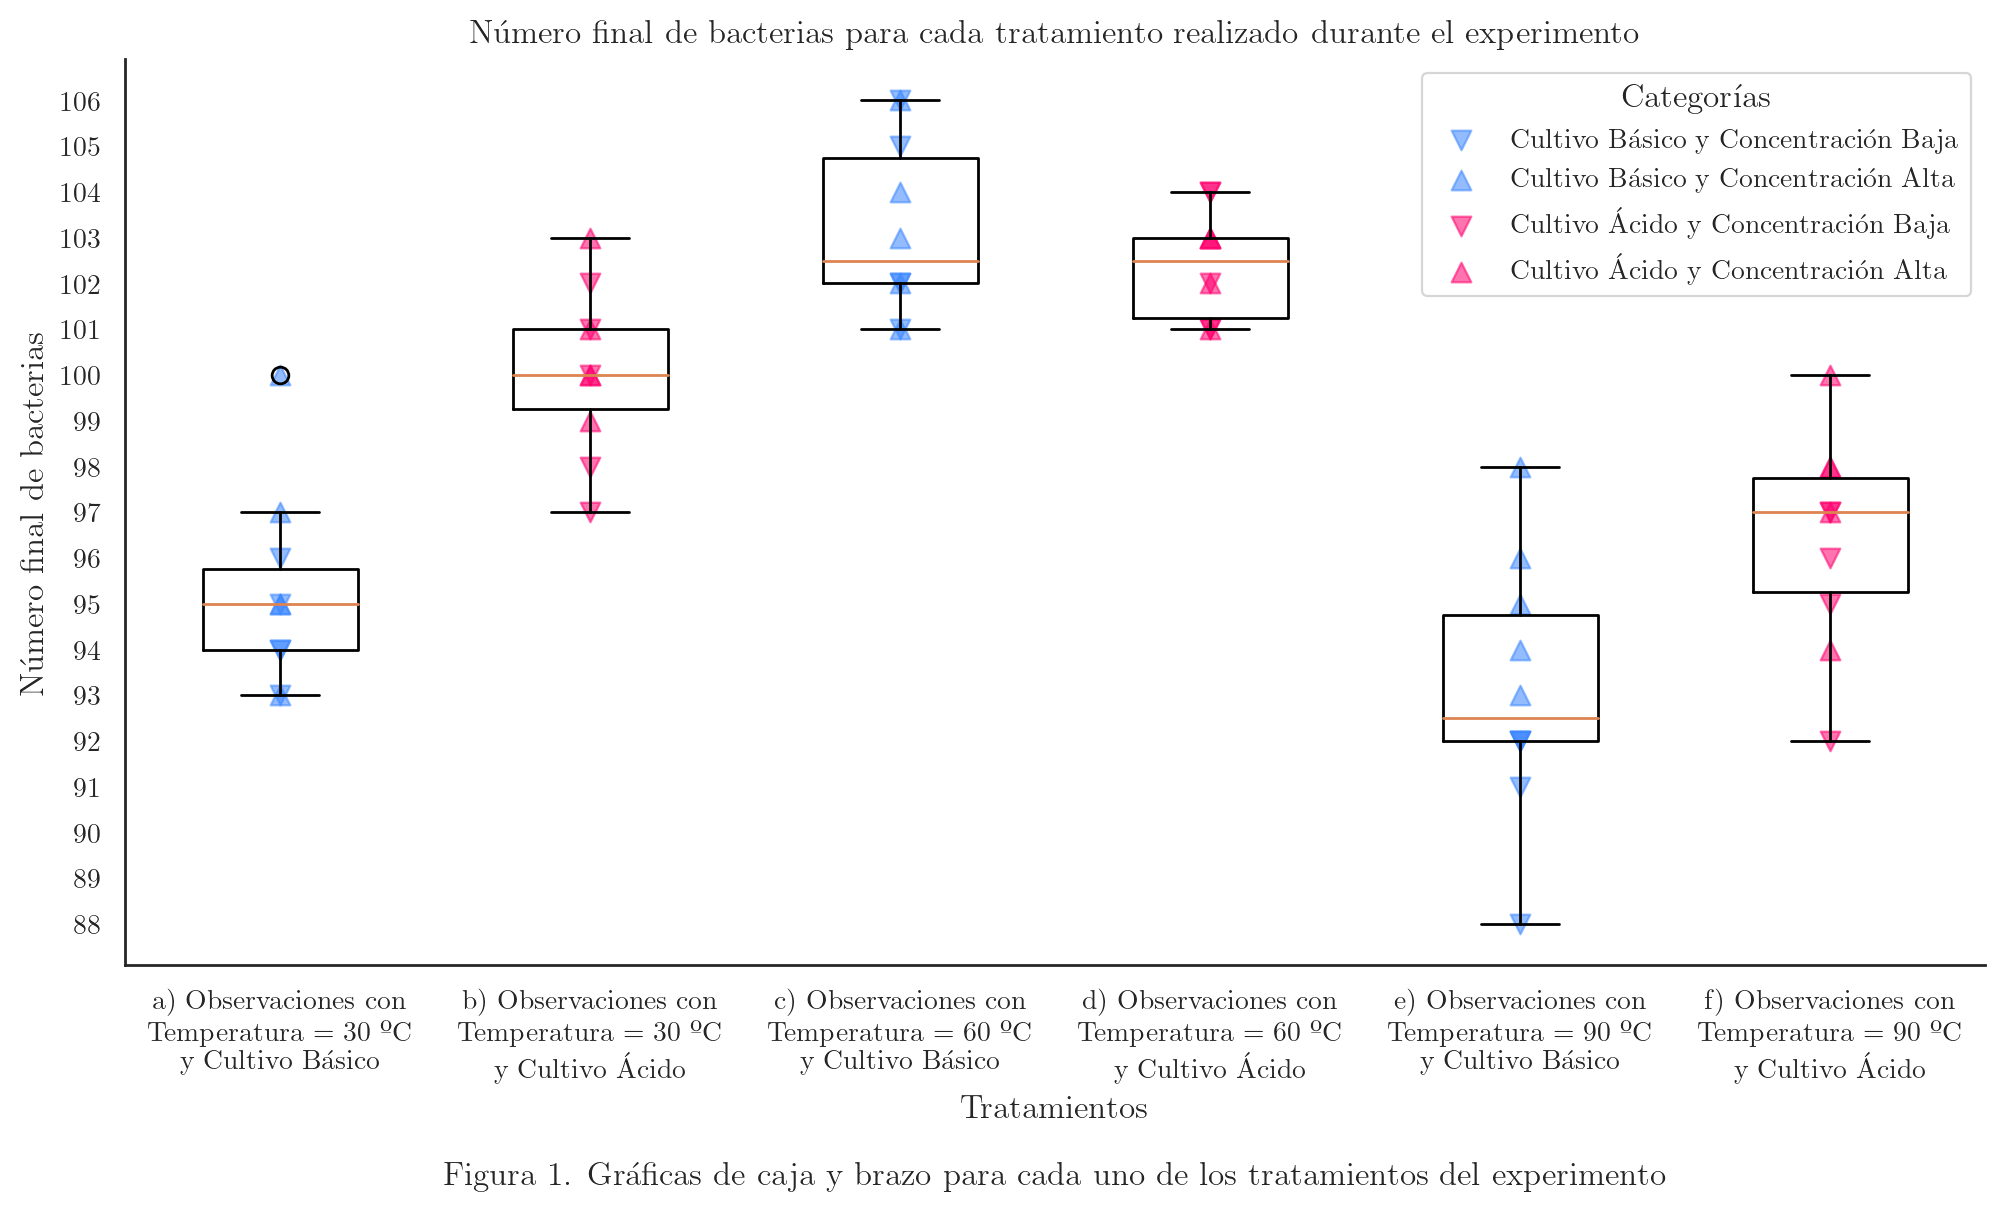

In [4]:
temperaturas = df["Temperatura [ºC]"].unique()

colors = {"Básico": "#3a86ff",
          "Ácido": "#ff006e"}
n = len(colors)

markers = {"Baja": "v",
           "Alta": "^"}

# Tamaños de fuente
big = 12
small = 10

s = 50

data = []
ticks = []
ticks_labels = []

panel_id = [["a) ", "b) "], ["c) ", "d) "], ["e) ", "f) "]]

plt.figure(figsize = (12, 6))

for i, temperatura in enumerate(temperaturas):
    for j, (cultivo, color) in enumerate(colors.items()):
        # Construir datos para boxplots
        matching_indices_box_plot = (df["Temperatura [ºC]"] == temperatura) & (df["Cultivo"] == cultivo)
        data.append(df.loc[matching_indices_box_plot, y].to_list())
        
        tick_label = panel_id[i][j] + f"Observaciones con \n Temperatura = {temperatura} ºC \n y Cultivo {cultivo}"
        ticks_labels.append(tick_label)
        
        current_panel = n*i + j + 1
        
        # Incluir los puntos en cada boxplot
        for concentracion, marker in markers.items():
            matching_indices_scatter_plot = matching_indices_box_plot & (df["Concentración"] == concentracion)
            
            if current_panel <= 2: # Para que no se repitan en el legend
                label = f"Cultivo {cultivo} y Concentración {concentracion}"
            else:
                label = ""
                
            plt.scatter([current_panel for i in range(0,len(df[matching_indices_scatter_plot].index))], 
                        df.loc[matching_indices_scatter_plot, y], 
                        c = color, 
                        marker = marker,
                        s = s, 
                        alpha = 0.55,
                        label = label)

plt.boxplot(data)
sns.despine()
plt.legend(fontsize=small, title="Categorías", title_fontsize=big)
plt.xticks(range(1, len(data)+1), ticks_labels)
plt.yticks(range(88, 107))
plt.tick_params(axis = 'both', which = 'major', labelsize = small)
plt.xlabel("Tratamientos\n\nFigura 1. Gráficas de caja y brazo para cada uno de los tratamientos del experimento",fontsize=big)
plt.ylabel(y, fontsize=big)
plt.title("Número final de bacterias para cada tratamiento realizado durante el experimento", fontsize=big)
plt.show()

##### `Temperatura` 

* **30 ºC**: En las gráficas de caja y brazo a) y b) de la Figura 1 se encuentran los resultados para un valor de `Temperatura` de 30 ºC. Uniendo los resultados de ambos tipos de `Cultivo` (Ácido y Básico) el `Número final de bacterias` se encuentra entre 93 y 103 unidades y tiene un valor medio de 97.65. En este caso la mediana del `Número final de bacterias` tuvo un incremento de 95 a 100 al pasar de un `Cultivo` Básico a un `Cultivo` Ácido.


* **60 ºC**: En las gráficas de caja y brazo c) y d) de la Figura 1 se encuentran los resultados para un valor de `Temperatura` de 60 ºC. Uniendo los resultados de ambos tipos de `Cultivo` (Ácido y Básico) el `Número final de bacterias` se encuentra entre 101 y 106 unidades y tiene un valor medio de 102.8. En este caso la mediana del `Número final de bacterias` no tuvo cambio al pasar de un `Cultivo` Básico a un `Cultivo` Ácido.


* **90 ºC**: En las gráficas de caja y brazo e) y f) de la Figura 1 se encuentran los resultados para un valor de `Temperatura` de 90 ºC. Uniendo los resultados de ambos tipos de `Cultivo` (Ácido y Básico) el `Número final de bacterias` se encuentra entre 88 y 100 unidades y tiene un valor medio de 94.75. En este caso la mediana del `Número final de bacterias` tuvo un incremento de 92.5 a 97 al pasar de un `Cultivo` Básico a un `Cultivo` Ácido.

##### Comentarios generales

El análisis anterior sugiere que el `Número final de bacterias` varía dependiendo de la `Temperatura` en el sentido de que el `Número final de bacterias` tiende a ser mayor si la `Temperatura` es de 60 ºC, menor si es de 30 ºC y aún menor si es de 90 ºC.

Para los niveles de `Temperatura` de 30 ºC y 90 ºC, el `Número final de bacterias` tiende a aumentar si el tipo de `Cultivo` cambia de Básico a Ácido. Esto sugiere que el tipo de `Cultivo` influye sobre el `Número final de bacterias` al menos para estos dos casos. La relación entre `Cultivo` y `Número final de bacterias` no es del todo clara para el caso de una `Temperatura` de 60 ºC.

La situación es ambigua con respecto a los niveles de `Concentración` ya que, para casi todos los tratamientos, es posible encontrar observaciones con niveles de `Concentración` tanto Baja como Alta en ambos brazos de las gráficas de caja y brazo. Esto sugiere que el nivel de `Concentración` no tiene una gran influencia sobre el `Número final de bacterias`.

# ¿Puede considerar que hay diferencia entre los niveles medios de temperatura? Esto es, identifica efectos sobre el número de bacterias por cambio en los niveles de temperatura?

In [5]:
# Obtener variables indicadoras para cada variable categórica

# Abreviar los nombres de las columnas categóricas
abbreviations = ["t", "k", "c"]

x = [] # Lista para almacenar los nombres de las variables indicadoras generadas

for category, abbreviation in zip(categorical, abbreviations):
    values = df[category].unique() # Valores distintos de la categoría actual
    n = len(values) # Cantidad de valores distintos de la categoría actual
    
    for k, value in enumerate(values):
        matching_rows = (df[category] == value) # Filas correspondientes al valor actual de la categoría actual
        
        # Si la variable categórica tiene n valores se necesitan n-1 variables indicadoras
        levels = f"{{:0{n-1}b}}".format(k)[::-1] # Código binario con los valores de cada variable indicadora
        
        for j in range(n-1): # Asignar valores a las variables indicadoras
            # Nombre de la variable indicadora
            label = fr"${{{abbreviation}}}_{j+1}$" if n > 2 else fr"${{{abbreviation}}}$" 
            
            x.append(label) # Agregar indicadora a la lista
            
            df.loc[matching_rows, label] = int(levels[j])

import collections
x = list(collections.OrderedDict.fromkeys(x)) # Quitar duplicados manteniendo el orden

In [6]:
# Obtener interacciones entre las variables indicadoras

import itertools
combinations = list(itertools.combinations(x, 2))

for combination in combinations:
    if combination != ('${t}_1$', '${t}_2$'): # Incluir esta combinación ocasiona singularidad
        # label = f"Interacción {combination[0]} y {combination[1]}"
        label = fr"{combination[0]}{combination[1]}"
        x.append(label) # Agregar interacciones a la lista
    
        df[label] = df[combination[0]]*df[combination[1]]

Para responder a esta pregunta y a las siguientes cuatro, se propone el siguiente modelo de regresión lineal.

$$y = \beta_0 + \beta_1t_1 + \beta_2t_2 + \beta_3k + \beta_4c + \beta_5t_1k + \beta_6t_1c + \beta_7t_2k + \beta_8t_2c + \beta_9kc + \varepsilon$$

donde

* $y$ es la variable respuesta correspondiente al `Número final de bacterias`.

* $t_1$ y $t_2$ son los regresores correspondientes a las variables indicadoras asociadas con el nivel de `Temperatura`, donde
$$
(t_1,\,t_2) = 
\begin{cases}
(0,\,0) & \text{ si } \textsf{Temperatura} = 30 \text{ ºC} \\
(1,\,0) & \text{ si } \textsf{Temperatura} = 60 \text{ ºC} \\
(0,\,1) & \text{ si } \textsf{Temperatura} = 90 \text{ ºC} \\
\end{cases}
$$

* $k$ es el regresor correspondiente a la variable indicadora asociada con el tipo de `Cultivo`, donde
$$
k = 
\begin{cases}
0 & \text{ si } \textsf{Cultivo} = \text{Básico} \\
1 & \text{ si } \textsf{Cultivo} = \text{Ácido} \\
\end{cases}
$$

* $c$ es el regresor correspondiente a la variable indicadora asociada con el nivel de `Concentración`, donde
$$
c = 
\begin{cases}
0 & \text{ si } \textsf{Concentración} = \text{Baja} \\
1 & \text{ si } \textsf{Concentración} = \text{Alta} \\
\end{cases}
$$

* $\varepsilon$ es el término de error aleatorio.

Es importante resaltar que se pueden obtener 12 modelos diferentes como resultado de las distintas combinaciones de niveles de `Temperatura`, `Cultivo` y `Concentración`.

In [31]:
# # QUITAR SI OCUPA MUCHO ESPACIO.
# 
# 
# # modelos = pd.read_csv("modelos.csv")
# 
# for index, row in modelos.iterrows(): 
#     temperatura = row["Temperatura [ºC]"]
#     cultivo = row["Cultivo"]
#     concentracion = row["Concentración"]
#     t_1 = row["${t}_1$"]
#     t_2 = row["${t}_2$"]
#     k = row["${k}$"]
#     c = row["${c}$"]
#     modelo = row["Modelo"]
#     
#     descripcion = f"Para las observaciones obtenidas con una `Temperatura` de {temperatura} ºC, " \
#                   fr"con `Cultivo` {cultivo} y con `Concentración` {concentracion} " \
#                   fr"se tienen $t_1 = {{{t_1}}}$, $t_2 = {{{t_2}}}$, $k = {{{k}}}$ y $c = {{{c}}}$. " \
#                   f"Entonces, el modelo para este tratamiento es: "
#     display(Markdown(descripcion + modelo))
#     #display(Latex(modelo))
#     print("\n")

In [8]:
# ESTA INTERPRETACIÓN SÍ ES MUY IMPORTANTE PORQUE LE DA VALIDEZ A LAS RESPUESTAS DE ESTA Y LAS SIGUIENTES PREGUNTAS.

De modo que

* $\beta_0$ es el valor medio del `Número final de bacterias` para un nivel de `Temperatura` de 30 ºC con un tipo de `Cultivo` Básico y con `Concentración` Baja.

* $\beta_1$ es una medida del cambio en el `Número final de bacterias` al pasar de una `Temperatura` de 30 ºC a una `Temperatura` de 60 ºC.

* $\beta_2$ es una medida del cambio en el `Número final de bacterias` al pasar de una `Temperatura` de 30 ºC a una `Temperatura` de 90 ºC. Entonces, la cantidad $\beta_2$ - $\beta_1$ es una medida del cambio en el `Número final de bacterias` al pasar de una `Temperatura` de 60 ºC a una `Temperatura` de 90 ºC.

* $\beta_3$ es una medida del cambio en el `Número final de bacterias` al pasar de un `Cultivo` Básico a un `Cultivo` Ácido cuando la `Temperatura` es de 30 ºC.

* $\beta_4$ es una medida del cambio en el `Número final de bacterias` al pasar de una `Concentración` Baja a una `Concentración` Alta cuando la `Temperatura` es de 30 ºC.

* $\beta_5$ mide la interacción entre los regresores $t_1$ y $k$. La cantidad $\beta_3 + \beta_5$ es una medida del cambio en el `Número final de bacterias` al pasar de un `Cultivo` Básico a un `Cultivo` Ácido cuando la `Temperatura` es de 60 ºC.

* $\beta_6$ mide la interacción entre los regresores $t_1$ y $c$. La cantidad $\beta_4 + \beta_6$ es una medida del cambio en el `Número final de bacterias` al pasar de una `Concentración` Baja a una `Concentración` Alta cuando la `Temperatura` es de 60 ºC.

* $\beta_7$ mide la interacción entre los regresores $t_2$ y $k$. La cantidad $\beta_3 + \beta_7$ es una medida del cambio en el `Número final de bacterias` al pasar de un `Cultivo` Básico a un `Cultivo` Ácido cuando la `Temperatura` es de 90 ºC.

* $\beta_8$ mide la interacción entre los regresores $t_2$ y $c$. La cantidad $\beta_4 + \beta_8$ es una medida del cambio en el `Número final de bacterias` al pasar de una `Concentración` Baja a una `Concentración` Alta cuando la `Temperatura` es de 90 ºC.

* $\beta_9$ mide la interacción entre los regresores $k$ y $c$. La cantidad $\beta_9$ es un ajuste en el `Número final de bacterias` cuando el tipo de `Cultivo` es Ácido y la `Concentración` es Alta.


In [9]:
# OBTENER EL AJUSTE Y MOSTRARLO.
n = len(df.index)
k = len(x)
p = k + 1
m = len(df.drop_duplicates(subset=x).index)

ones = np.ones((n, 1))
X =  np.c_[ones, df[x].to_numpy()]

Y = df[y].to_numpy()

C = np.linalg.inv(np.dot(X.T, X))

beta = np.linalg.multi_dot([C, X.T, Y])

Y_fit = np.dot(X, beta)
df["Respuesta ajustada"] = Y_fit

residuals = Y - Y_fit
df["Residuales"] = residuals

def to_string(beta, x):
    regressors = [""]
    signs = []
    betas = []
    beta_first = True
    
    for value in beta:
        if value > 0:
            if beta_first:
                signs.append("")
            else:
                signs.append("+")
        else:
            signs.append("-")
        betas.append(str(abs(np.round(value,2))))
        beta_first = False

    for value in x:
        regressors.append(value)

    string = r"$\hat{y}$" + " ="
    for sign, coefficient, regressor in zip(signs, betas, regressors):
        string = string + f" {sign} {coefficient}{regressor}"

    return string

display(Markdown("El ajuste obtenido para el modelo propuesto está dado por"))
# display(Latex(to_string(beta, x))) # NO SÉ POR QUÉ NO SALE CENTRADO :(
# display(Markdown(to_string(beta,x)))
display(Markdown('$\hat{y}$ =  94.32 + 8.65${t}_1$ - 3.0${t}_2$ + 5.37${k}$ + 1.77${c}$ - 5.7${t}_1{k}$ - 1.3${t}_1{c}$ - 1.6${t}_2{k}$ + 1.8${t}_2{c}$ - 0.93${k}{c}$'))

El ajuste obtenido para el modelo propuesto está dado por

$\hat{y}$ =  94.32 + 8.65${t}_1$ - 3.0${t}_2$ + 5.37${k}$ + 1.77${c}$ - 5.7${t}_1{k}$ - 1.3${t}_1{c}$ - 1.6${t}_2{k}$ + 1.8${t}_2{c}$ - 0.93${k}{c}$

In [10]:
# MOSTRAR R^2 Y R^2 AJUSTADA.

SS_Res = np.sum((Y - Y_fit)**2)
MS_Res = SS_Res/(n - p)

Y_mean = np.repeat(Y.mean(), n)
SS_Tot = np.sum((Y - Y_mean)**2)

# SS_R = np.sum((Y_fit - Y_mean)**2)
# MS_R = SS_R/k

R_sq = np.round(100*(1 - SS_Res/SS_Tot),2)
R_sq_adj = np.round(100*(1 - ((SS_Res)/(n - p))/((SS_Tot)/(n - 1))),2)

#mensaje = fr"Para el ajuste obtenido se calculó un valor de $R^2$ de {R_sq} % " 
#mensaje = mensaje + r"y un valor de $R^2_{\text{ajustada}}$" + f" de {R_sq_adj} %. "
#mensaje = mensaje + "Esto quiere decir que los regresores incluidos en el modelo"
#mensaje = mensaje + "logran explicar una cantidad suficiente de la variabilidad de la respuesta."

mensaje = fr"Para el ajuste obtenido se calculó un valor de $R^2$ de {R_sq} % " + \
r"y un valor de $R^2_{\text{ajustada}}$" + f" de {R_sq_adj} %. " + \
"Esto quiere decir que los regresores incluidos en el modelo logran " + \
"explicar una cantidad suficiente de la variabilidad de la respuesta."

display(Markdown(mensaje))

Para el ajuste obtenido se calculó un valor de $R^2$ de 83.99 % y un valor de $R^2_{\text{ajustada}}$ de 81.11 %. Esto quiere decir que los regresores incluidos en el modelo logran explicar una cantidad suficiente de la variabilidad de la respuesta.

In [11]:
# COMPLEMENTO SI QUEDA ESPACIO/TIEMPO: PRUEBA DE FALTA DE AJUSTE, QUE ES INDEPENDIENTE DEL MODELO

A continuación se realizan algunas pruebas de hipótesis para análizar los efectos de los cambios de `Temperatura` sobre el `Número final de bacterias`.

In [12]:
# PARA RESPONDER A LA PREGUNTA 2, PROBAR
    # H_0: \beta_1 = 0 vs. H_1: \beta_1 \neq 0. RECHAZAR SI p < alpha.
    # H_0: \beta_1 = 0 vs. H_1: \beta_1 \neq 0. RECHAZAR SI p < alpha.
    # H_0: \beta_2 = 0 vs. H_1: \beta_2 \neq 0. RECHAZAR SI p < alpha.

# AL RECHAZAR ESTAS HIPÓTESIS SE PRUEBA QUE LA TEMPERATURA SÍ INFLUYE EN EL NÚMERO FINAL DE BACTERIAS

# Para darle formato a los valores p
def format_tex(float_number):
    if float_number == 0:
        mantissa_format = 1.11
        exponent = -16
    else:
        exponent = np.floor(np.log10(float_number))
        mantissa = float_number/10**exponent
        mantissa_format = str(mantissa)[0:4]
    return fr"{mantissa_format} $\times$ 10 $^{{{int(exponent)}}}$"

# Para probar H_0: \beta_j = beta_j^0 vs H_1: \beta_j \neq beta_j^0
def test_beta(j, beta_0 = 0, alpha = 0.05):
    beta_j = beta[j]
    C_jj = np.diag(C)[j]
    std_error = np.sqrt(MS_Res*C_jj)
    t_0 = (beta_j - beta_0)/(std_error)
    p_value = stats.t.cdf(-abs(t_0), n - p) + 1-stats.t.cdf(abs(t_0), n - p)
    
    pretty_t_0 = np.round(t_0,2)
    pretty_p_value = format_tex(p_value)
    
    mensaje = fr"* Para $H_0$: $\beta_{j}$ = {beta_0} vs. $H_1$: $\beta_{j}$ $\neq$ {beta_0} " + \
    fr" se obtuvo un estadístico $t$ = {pretty_t_0} y un valor $p$ = {pretty_p_value}"
    
    if p_value < alpha:
        complemento = r", que es lo suficientemente pequeño para rechazar $H_0$."
    else:
        complemento = r", que es lo suficientemente grande para no rechazar $H_0$."
    
    display(Markdown(mensaje + complemento))
    
    return t_0, p_value

t_0, p_value = test_beta(0)
t_0, p_value = test_beta(1)
t_0, p_value = test_beta(2)

* Para $H_0$: $\beta_0$ = 0 vs. $H_1$: $\beta_0$ $\neq$ 0  se obtuvo un estadístico $t$ = 124.55 y un valor $p$ = 1.11 $\times$ 10 $^{-16}$, que es lo suficientemente pequeño para rechazar $H_0$.

* Para $H_0$: $\beta_1$ = 0 vs. $H_1$: $\beta_1$ $\neq$ 0  se obtuvo un estadístico $t$ = 8.51 y un valor $p$ = 2.69 $\times$ 10 $^{-11}$, que es lo suficientemente pequeño para rechazar $H_0$.

* Para $H_0$: $\beta_2$ = 0 vs. $H_1$: $\beta_2$ $\neq$ 0  se obtuvo un estadístico $t$ = -2.95 y un valor $p$ = 4.78 $\times$ 10 $^{-3}$, que es lo suficientemente pequeño para rechazar $H_0$.

De acuerdo con los resultados de las pruebas de hipótesis anteriores, es posible afirmar que no hay evidencia de que los coeficientes asociados con los cambios de `Temperatura` sean negligibles y, por lo tanto, es posible concluir que los efectos sobre el `Número final de bacterias` por cambio en los niveles de `Temperatura` sí son identificables.

# ¿Es distinta la respuesta dependiendo del cultivo empleado?

In [13]:
# PARA RESPONDER A LA PREGUNTA 3, PROBAR
    # H_0: \beta_3 = 0 vs. H_1: \beta_3 \neq 0. RECHAZAR SI p < alpha.

t_0, p_value = test_beta(3)

# AL RECHAZAR ESTA HIPÓTESIS SE PRUEBA QUE EL TIPO DE CULTIVO SÍ INFLUYE EN EL NÚMERO FINAL DE BACTERIAS

* Para $H_0$: $\beta_3$ = 0 vs. $H_1$: $\beta_3$ $\neq$ 0  se obtuvo un estadístico $t$ = 5.6 y un valor $p$ = 9.00 $\times$ 10 $^{-7}$, que es lo suficientemente pequeño para rechazar $H_0$.

Como rechazamos la opción que $\beta_3$ tome el valor de cero, esto implica que el tipo de cultivo que se emplea en las muestras sí afecta o sí tiene un impacto significativo en el número de bacterias encontradas.

# ¿Consideraría que los factores interactúan?

A continuación se harán varias pruebas de hipótesis que ayudarán a discernir si los distintos factores (`Temperatura`, `Cultivo` y `Concentración`) interactúan entre ellos en el resultado final de número de bacterias.

In [14]:
# PARA RESPONDER A LA PREGUNTA 4, PROBAR
    # H_0: \beta_5 = 0 vs. H_1: \beta_5 \neq 0. RECHAZAR SI p < alpha.
    # H_0: \beta_6 = 0 vs. H_1: \beta_6 \neq 0. RECHAZAR SI p < alpha.
    # H_0: \beta_7 = 0 vs. H_1: \beta_7 \neq 0. RECHAZAR SI p < alpha.
    # H_0: \beta_8 = 0 vs. H_1: \beta_8 \neq 0. RECHAZAR SI p < alpha.
    # H_0: \beta_9 = 0 vs. H_1: \beta_9 \neq 0. RECHAZAR SI p < alpha.

# INDICAR CUÁLES FACTORES INTERACTÚAN Y CUÁLES NO 
# DEPENDIENDO DE CUÁLES HIPÓTESIS SE RECHACEN Y CUÁLES NO, RESPECTIVAMENTE.

In [15]:
t_0, p_value = test_beta(5)
t_0, p_value = test_beta(6)
t_0, p_value = test_beta(7)
t_0, p_value = test_beta(8)
t_0, p_value = test_beta(9)

* Para $H_0$: $\beta_5$ = 0 vs. $H_1$: $\beta_5$ $\neq$ 0  se obtuvo un estadístico $t$ = -4.86 y un valor $p$ = 1.20 $\times$ 10 $^{-5}$, que es lo suficientemente pequeño para rechazar $H_0$.

* Para $H_0$: $\beta_6$ = 0 vs. $H_1$: $\beta_6$ $\neq$ 0  se obtuvo un estadístico $t$ = -1.11 y un valor $p$ = 2.73 $\times$ 10 $^{-1}$, que es lo suficientemente grande para no rechazar $H_0$.

* Para $H_0$: $\beta_7$ = 0 vs. $H_1$: $\beta_7$ $\neq$ 0  se obtuvo un estadístico $t$ = -1.36 y un valor $p$ = 1.78 $\times$ 10 $^{-1}$, que es lo suficientemente grande para no rechazar $H_0$.

* Para $H_0$: $\beta_8$ = 0 vs. $H_1$: $\beta_8$ $\neq$ 0  se obtuvo un estadístico $t$ = 1.53 y un valor $p$ = 1.31 $\times$ 10 $^{-1}$, que es lo suficientemente grande para no rechazar $H_0$.

* Para $H_0$: $\beta_9$ = 0 vs. $H_1$: $\beta_9$ $\neq$ 0  se obtuvo un estadístico $t$ = -0.97 y un valor $p$ = 3.34 $\times$ 10 $^{-1}$, que es lo suficientemente grande para no rechazar $H_0$.

Como podemos observar, todos los valores p de las pruebas de hipótesis son valores grandes (mayores a 0.05), con excepción del valor de la prueba para $\beta_5$. Sin embargo, como $\beta_5$ indica la interacción entre el cambio de 30ºC a 60ºC de `Temperatura` y el tipo de `Cultivo`, también tenemos que tomar en cuenta $\beta_6$ para modelar la interacción total entre estas dos variables.

# Valide su modelo mediante el análisis de los residuales.

Realizaremos un análisis de residuales para ver si el modelo cumple con todos los supuestos:
1. Varianza constante
2. Errores independientes
3. Errores se distribuyen normal con media 0

In [16]:
dummys_df = df[['Número final de bacterias', '${t}_1$', '${t}_2$', '${k}$', '${c}$',
       '${t}_1$${k}$', '${t}_1$${c}$', '${t}_2$${k}$', '${t}_2$${c}$',
       '${k}$${c}$']]
dummys_df.columns = ['y', 't1', 't2', 'k', 'c', 't1k', 't1c', 't2k', 't2c', 'kc']

In [17]:
formula_str = 'y~t1+t2+k+c+t1:k+t1:c+t2:k+t2:c+k:c'
model=sm.ols(formula=formula_str, data=dummys_df)
fitted = model.fit()

In [18]:
def format_plot(ax, x_label = 'x', y_label = 'y', caption = None, despine = True):
    AX_SIZE = 10
    if despine:
        sns.despine()

    if caption:
        x_label = x_label + '\n\n' + caption

    ax.set_xlabel(x_label, fontsize = AX_SIZE)
    ax.set_ylabel(y_label, fontsize = AX_SIZE)

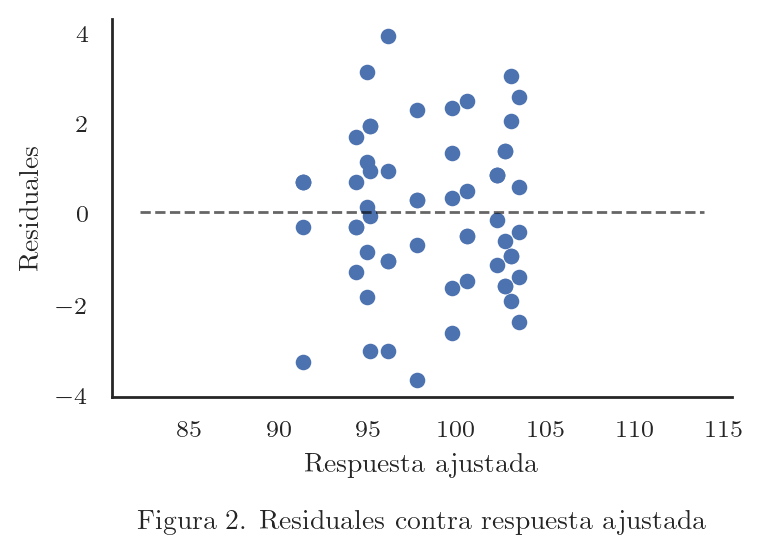

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(4, 2.5))
# grafica residuales
xmin=min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
axes.hlines(y=0, xmin=xmin*0.9, xmax=xmax*1.1, color='black',linestyle='--',lw=1, alpha = 0.6)
axes.scatter(fitted.fittedvalues, fitted.resid)
format_plot(
    axes,
    x_label = 'Respuesta ajustada',
    y_label = 'Residuales',
    caption = 'Figura 2. Residuales contra respuesta ajustada'
)
plt.show()

En la figura 2 vemos que el modelo sí cumple con el supuesto de homocedasticidad pues la varianza de los residuales es prácticamente constante. Al inicio tiene una menor varianza sin embargo después se estabiliza y se mantene constante.

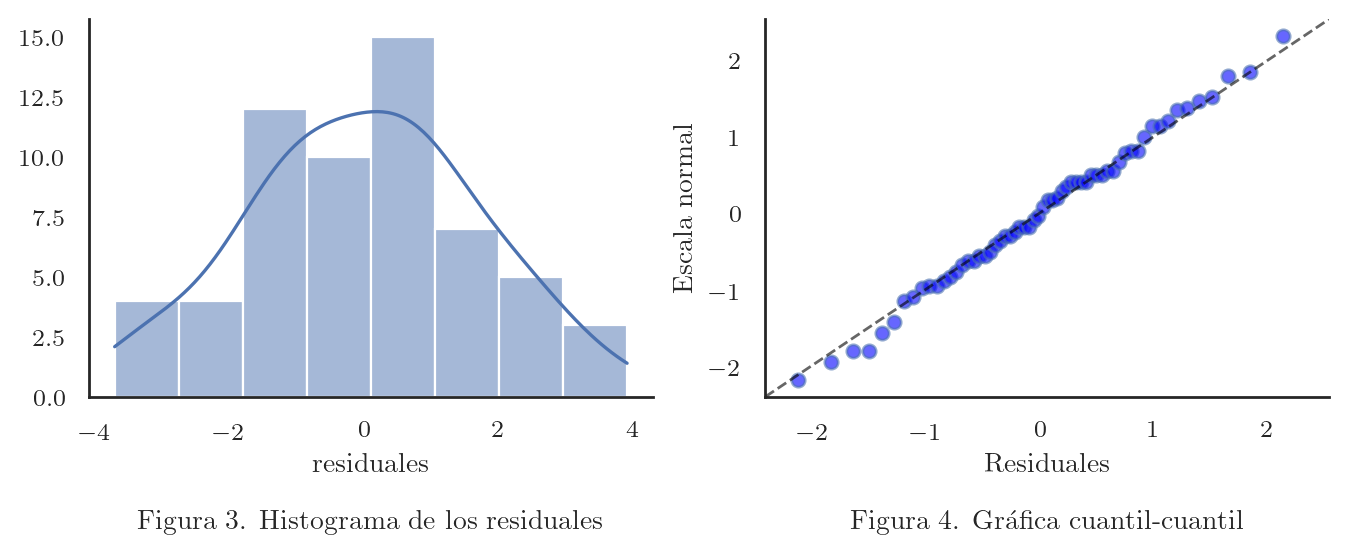

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(FIG_WIDTH*2, FIG_HEIGHT))
# Histograma
sns.histplot(fitted.resid, ax = axes[0], kde = True)
format_plot(
    ax = axes[0],
    x_label = 'residuales',
    y_label = '',
    caption = 'Figura 3. Histograma de los residuales'
)
#Gráfica cuantil-cuantil
pp = ProbPlot(fitted.resid_pearson, fit=True)
qq = pp.qqplot(alpha=0.6, ax = axes[1])
qqline(qq.axes[1], line='45', color='black',linestyle='--',lw=1, alpha = 0.6)
format_plot(
    axes[1],
    x_label = 'Residuales',
    y_label = 'Escala normal',
    caption = 'Figura 4. Gráfica cuantil-cuantil'
)
plt.show()



En la Figura 3 vemos que, aunque no es idéntica, la distribución de los residuales se asemeja bastante a la de una normal. Esto se confirma con la gráfica cuantil-cuantil de la Figura 4 ya que, salvo al inicio y al final, los residuales sí se ajustan a la recta y por lo tanto cumplen con el supuesto de normalidad.

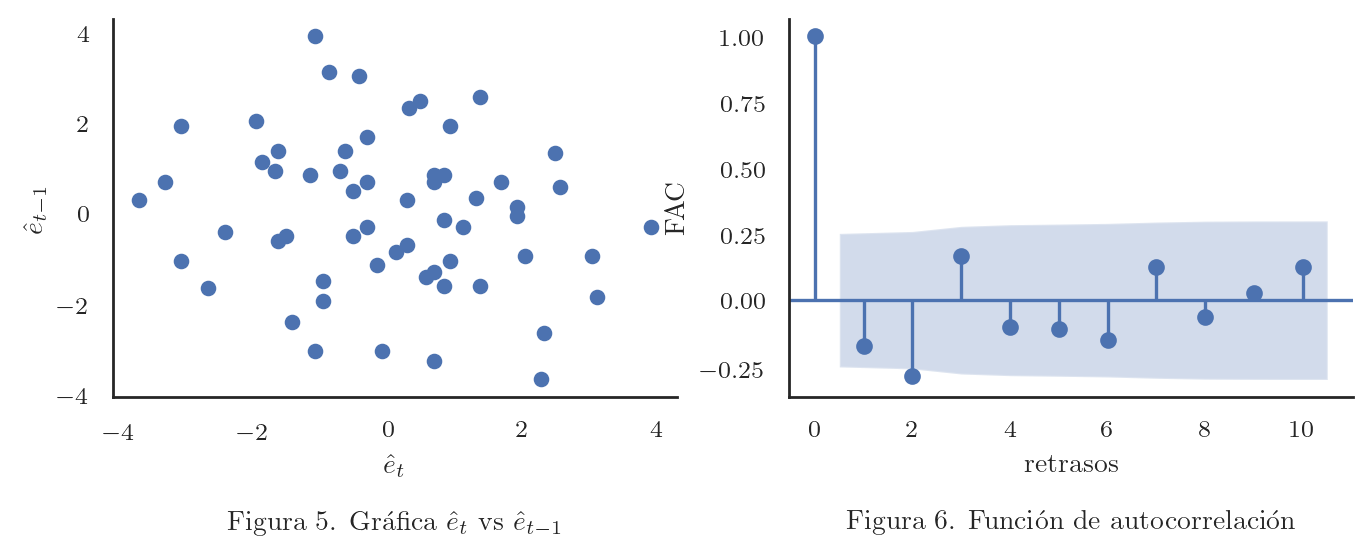

In [21]:
#------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(FIG_WIDTH*2, FIG_HEIGHT))
#plot acf
e1 = list(fitted.resid)
e = e1[:-1]
e1 = e1[1:]
axes[0].scatter(x = e1, y = e)
format_plot(
    axes[0],
    x_label = '$\hat{e}_t$',
    y_label = '$\hat{e}_{t-1}$',
    caption = 'Figura 5. Gráfica $\hat{e}_t$ vs $\hat{e}_{t-1}$'
)
smt.graphics.plot_acf(
    fitted.resid, 
    lags=10, 
    alpha=0.05,
    ax = axes[1],
    title = ''
)
format_plot(
    axes[1],
    x_label = 'retrasos',
    y_label = 'FAC',
    caption = 'Figura 6. Función de autocorrelación'
)
plt.show()

Finalmente con la Figura 5 y la Figura 6 vemos que los residuales no presentan ninguna correlación aparente entre ellos y que la correlación de orden uno es muy pequeña por lo que también se cumple el supuesto de independencia.

Una vez que nuestros residuales sí cumplen los 3 supuestos podemos afirmar que nuestro modelo es válido y útil para analizar nuestros datos.

In [22]:
influence = OLSInfluence(fitted)

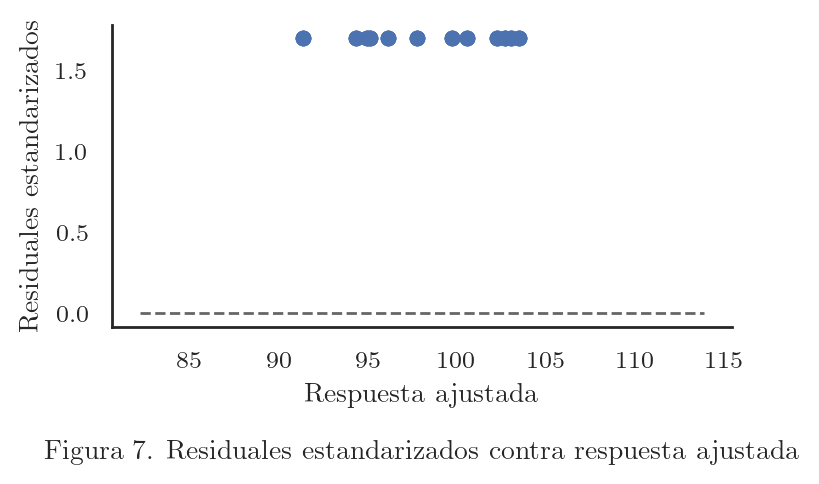

In [33]:
fig, axes = plt.subplots(1, 1, figsize=(4, 2))
# grafica residuales
xmin=min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
axes.hlines(y=0, xmin=xmin*0.9, xmax=xmax*1.1, color='black',linestyle='--',lw=1, alpha = 0.6)
axes.scatter(fitted.fittedvalues, influence.resid_std)
format_plot(
    axes,
    x_label = 'Respuesta ajustada',
    y_label = 'Residuales estandarizados',
    caption = 'Figura 7. Residuales estandarizados contra respuesta ajustada'
)
plt.show()

Finalmente de la Figura 7 vemos que los residuales estandarizados son menores que 1.75 y mayores que 0 por lo que podemos concluir que nuestra muestra no cuenta con valores atípicos.

# ¿Considera que es necesario distinguir entre los niveles bajo y alto de la concentración del cultivo?

Para la prueba de hipótesis $H_0: \beta_4 = 0$ vs. $H_1: \beta_4 \neq 0$ se obtuvo un estadístico $t_4 = 1.84$ y un resultante valor $p = 7.11 × 10^{-2}$, que no es lo suficientemente pequeño como para rechazar la hipótesis $H_0$. Esto significa que el coeficiente $\beta_4$ no es significativo y por lo tanto no es necesario distinguir entre los niveles de concentración ya que no nos brinda información extra.

# Concluya el reporte resaltando lo encontrado en su análisis.

In [26]:
formula_str = 'y~t1+t2+k+t1:k+t2:k+t2:c+t1:c+c+k:c'
final_model2 = sm.ols(formula=formula_str, data=dummys_df)
final_fitted2 = final_model2.fit()
anova = st.anova_lm(final_fitted2, typ=1)
anova = anova.drop(columns = ['sum_sq', 'mean_sq'])
display(anova)

,df,F,PR(>F)
t1,1.0,1.6880e+02,1.1941e-17
t2,1.0,2.4443e+01,9.0172e-06
k,1.0,2.6526e+01,4.4140e-06
t1:k,1.0,2.3261e+01,1.3658e-05
t2:k,1.0,1.8601e+00,1.7872e-01
t2:c,1.0,1.3965e+01,4.7895e-04
t1:c,1.0,5.7349e-28,1.0000e+00
c,1.0,2.4559e+00,1.2339e-01
k:c,1.0,9.4943e-01,3.3456e-01
Residual,50.0,NaN,NaN


Realizamos un análisis de varianza para ver cuáles regresores podemos eliminar de nuestro modelo. Como se observó en las pruebas de hipótesis realizaddas en secciones anteriores tanto la `Temperatura` como el tipo de `Cultivo`, así como su interacción, son variables importantes para determinar el `número de bacterias` final. 

Además con este análisis observamos que la interacción entre la `Temperatura` y la `Concentración` también es un regresor importante para explicar nuestros datos ya que tiene un valor p de $4.79 \times 10 ^{-4} < 0.05$. Es importante notar que la prueba de hipótesis de la pregunta 5 nos indica que si la iteracción entre `Temperatura` y `Concentración` (`t2:c`) es el último regresor en agregarse al modelo, entonces no es muy significativo. Sin embargo, la tabla anterior nos indica que si solo tomamos en cuenta la `Temperatura` y el `Cultivo` en nuestro modelo, agregar el regresor `t2:c` sí nos ayuda a explicar de mejor manera nuestros datos. Por el *Principio de Herencia* al agregar la interacción entre `Temperatura` y `Concentración` también debemos de agregar el regresor de `Concentración` a la muestra aunque este no sea tan significativo.

In [27]:
formula_str = 'y~t1+t2+k+t1:k+t2:k+t2:c+t1:c+c'
final_model = sm.ols(formula=formula_str, data=dummys_df)
final_fitted = final_model.fit()
#final_fitted.summary()

Por lo tanto, el modelo seleccionado para explicar el `número de bacterias` es de la forma:
$$y=\beta_0 + \beta_1 t_1 + \beta_2 t_2 + \beta_3 k + \beta_4 c + \beta_5 t_1k + \beta_6 t_2k + \beta_7 t_1c + \beta_8 t_2c + \varepsilon$$
y el modelo ajustado es:
$$\hat{y}= 94.55 + 8.65t_1 - 3.00t_2 + 4.90k + 1.30c - 5.70t_1k -1.60t_2k - 1.30t_1c + 1.80t_2c $$

In [28]:
def predict(df, fitted_model, mean = 'Número de bacterias', ci_upper = 'CI_upper', ci_lower = 'CI_lower'):
    prediction = fitted_model.get_prediction(df)
    
    df[mean] = prediction.predicted_mean
    
    df[ci_lower], df[ci_upper] = prediction.conf_int().T
        
    return df

def get_actual_mean(df, t1, t2, k, c, full = True):
    aux = df[(df['t1'] == t1) &  
             (df['t2'] == t2) &
             (df['k'] == k)
            ]
    
    if full:
        aux = aux[aux['c'] == c]
        
    return np.mean(aux['y'])

def plot_ci(modelos, ci_lower, ci_upper, y, y_approx, label):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    for lower, upper, actual_mean, expected_mean, y in zip(modelos[ci_lower], modelos[ci_upper], modelos[y], modelos[y_approx], range(len(modelos))):
        if y == 1:
            ax.plot((lower,upper),(y,y),'ro-', zorder = -1, label = 'Intervalo de confianza')
            ax.scatter(actual_mean, y, color = 'blue', marker=(5, 1), alpha = 0.6, s = 20, zorder = 1, label = 'Media observada')
            ax.scatter(expected_mean, y, color = 'green', marker='o', alpha = 0.6, s = 15, zorder = 1, label = 'Media esperada')
        else:
            ax.plot((lower,upper),(y,y),'ro-', zorder = -1)
            ax.scatter(actual_mean, y, color = 'blue', marker=(5, 1), alpha = 0.6, s = 20, zorder = 1)
            ax.scatter(expected_mean, y, color = 'green', marker='o', alpha = 0.6, s = 15, zorder = 1)
            
    ax.yaxis.set_ticks(range(len(modelos)))
    ax.yaxis.set_ticklabels(modelos[label])
    
    plt.tick_params(axis = 'both', which = 'major', labelsize = 8)
    
    ax.legend(fontsize=8)
    format_plot(
        ax,
        x_label = 'Número esperado de bacterias',
        y_label = '',
        caption = 'Figura 8. Intervalos de confianza del $95\%$ para los diferentes experimentos'
    )
    plt.show()


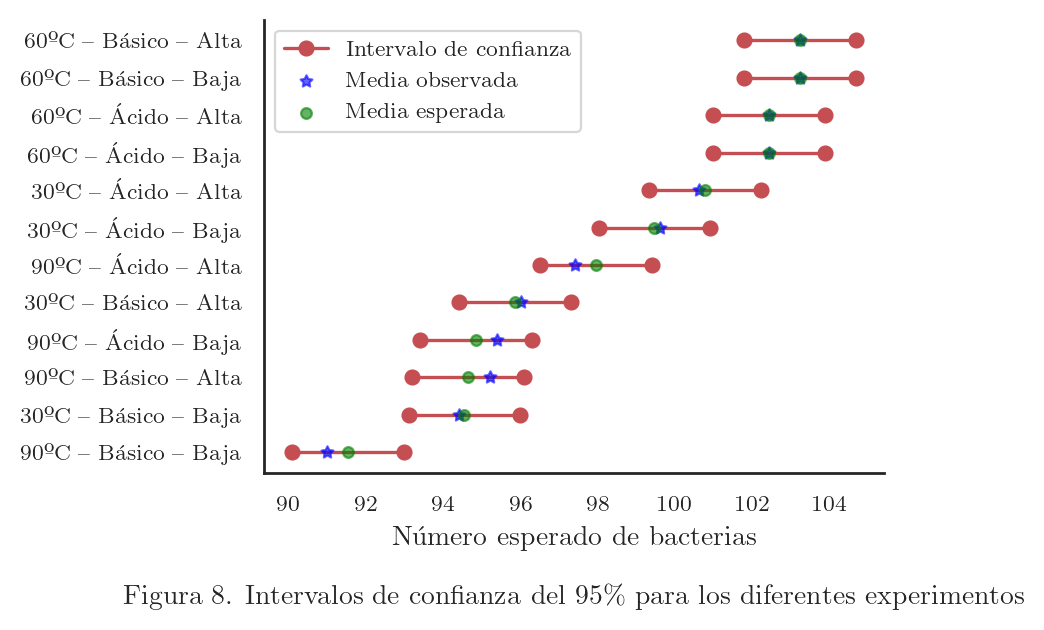

In [29]:
modelos = pd.read_csv('modelos.csv')
modelos['Temperatura [ºC]'] = modelos['Temperatura [ºC]'].astype(str)
modelos.columns = ['Temperatura [ºC]', 't1', 't2', 'Cultivo', 'k',
       'Concentración', 'c', 'Modelo']

modelos = predict(modelos,
                  final_fitted,
                  'Número de bacterias ($\hat{y_2})$',
                  'CI_upper',
                  'CI_lower',
                 )

modelos = modelos.reset_index(drop = True)
modelos['y'] = [get_actual_mean(dummys_df, modelos['t1'][i], modelos['t2'][i], modelos['k'][i], modelos['c'][i], full = True) for i in range(len(modelos))]

modelos = modelos.drop(columns = ['t1', 't2', 'k', 'c', 'Modelo'])
modelos['label'] = modelos['Temperatura [ºC]'] + 'ºC – ' +  modelos['Cultivo'] + ' – ' + modelos['Concentración']

# gráfica para modelo 2
modelos = modelos.sort_values(by = 'Número de bacterias ($\hat{y_2})$', ascending = True)
plot_ci(modelos, 
        ci_lower = 'CI_lower', 
        ci_upper = 'CI_upper', 
        y = 'y', 
        y_approx = 'Número de bacterias ($\hat{y_2})$',
        label = 'label')

modelos = modelos.drop(columns = ['y','label', 'CI_lower', 'CI_upper'])
modelos = modelos.sort_values(by = 'Número de bacterias ($\hat{y_2})$', ascending = False).reset_index(drop = True)


En la Figura 8 vemos el ajuste final de nuestro modelo el cual tiene un buen ajuste ya que las medias observadas sí están dentro de los intervalos de confianza de las predicciones del modelo. 

Notamos que las bacterias reaccionan mejor a una temperatura de 60ºC sin importar el tipo de cultivo ya que entre el cultivo ácido y básico hay menos de un punto de diferencia. Además en el caso de los 60ºC no importa la concentración inicial del experimento pues con ambas se obtienen los mismos resultados. Por el otro lado, para temperaturas de 30ºC y 90ºC la bacterias crecen mejor con un cultivo ácido y concentraciones iniciales altas, pero prefieren temperaturas más bajas (30ºC). Todo esto concuerda con nuestras observaciones iniciales.